In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [5]:
train_df = pd.read_table('E:\Major Project\Data\WikiQACorpus\WikiQA-train.tsv')

In [6]:
train_df.head()

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
0,Q1,how are glacier caves formed?,D1,Glacier cave,D1-0,A partly submerged glacier cave on Perito More...,0
1,Q1,how are glacier caves formed?,D1,Glacier cave,D1-1,The ice facade is approximately 60 m high,0
2,Q1,how are glacier caves formed?,D1,Glacier cave,D1-2,Ice formations in the Titlis glacier cave,0
3,Q1,how are glacier caves formed?,D1,Glacier cave,D1-3,A glacier cave is a cave formed within the ice...,1
4,Q1,how are glacier caves formed?,D1,Glacier cave,D1-4,"Glacier caves are often called ice caves , but...",0


In [7]:
train_df.count()

QuestionID       20347
Question         20347
DocumentID       20347
DocumentTitle    20347
SentenceID       20347
Sentence         20347
Label            20347
dtype: int64

In [8]:
train_df.tail()

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
20342,Q3043,what is section eight housing,D2807,Section 8 (housing),D2807-8,A tenant who leaves a subsidized project will ...,0
20343,Q3043,what is section eight housing,D2807,Section 8 (housing),D2807-9,The United States Department of Housing and Ur...,0
20344,Q3044,what is the main type of restaurant,D2808,Category:Types of restaurants,D2808-0,Restaurants categorized by type and informatio...,0
20345,Q3046,what is us dollar worth based on,D2810,History of the United States dollar,D2810-0,U.S. Federal Reserve notes in the mid-1990s,0
20346,Q3046,what is us dollar worth based on,D2810,History of the United States dollar,D2810-1,The history of the United States dollar covers...,0


In [14]:
print "# correct answer sentences : ", train_df['Label'].sum()
print "# candidate answer sentences : ", train_df['Label'].count()

# correct answer sentences :  1039
# candidate answer sentences :  20347


In [21]:
question_counts = train_df['QuestionID'].value_counts()

In [34]:
positive_questions = train_df['QuestionID'][train_df['Label'] == 1]

In [40]:
positive_questionIDs = positive_questions.tolist()

In [41]:
positive_questions_df = train_df[train_df['QuestionID'] in positive_questionIDs]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [47]:
train_df['QuestionID'] in 

0      True
1      True
2      True
3      True
4      True
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
...
20332    False
20333    False
20334    False
20335    False
20336    False
20337    False
20338    False
20339    False
20340    False
20341    False
20342    False
20343    False
20344    False
20345    False
20346    False
Name: QuestionID, Length: 20347, dtype: bool

In [48]:
def checkIfPositive(qID):
    if qID in positive_questionIDs:
        return True
    else:
        return False

In [61]:
train_df.groupby('QuestionID').aggregate(sum)['Label'] == 0

0    1245
1     744
2     103
3      20
7       2
5       1
6       1
4       1
dtype: int64

In [79]:
#sample only positive questions
positiveTrain_df = pd.DataFrame(columns = train_df.columns)
for index, row in train_df.iterrows():
    if row['QuestionID'] in positive_questionIDs:
        #positiveTrain_df.add(index, row)
        positiveTrain_df.loc[-1] = row  # adding a row
        positiveTrain_df.index = positiveTrain_df.index + 1  # shifting index


In [83]:
positiveTrain_df['Label'].sum()

1039L

In [192]:
print "# Answer Sentences"
print positiveTrain_df.groupby('QuestionID').aggregate(sum)['Label'].value_counts()
print "\n# Questions with answers"
print positiveTrain_df.groupby('QuestionID').aggregate(sum)['Label'].value_counts().sum()

# Answer Sentences
1    744
2    103
3     20
7      2
6      1
5      1
4      1
dtype: int64

# Questions with answers
872


In [92]:
plt.style.use('ggplot')

'\nfor i, label in enumerate(list(df_temp.index)):\n    score = df_temp.ix[label][1]\n    ax.annotate(str(score), (i, score + 0.2))\n    '

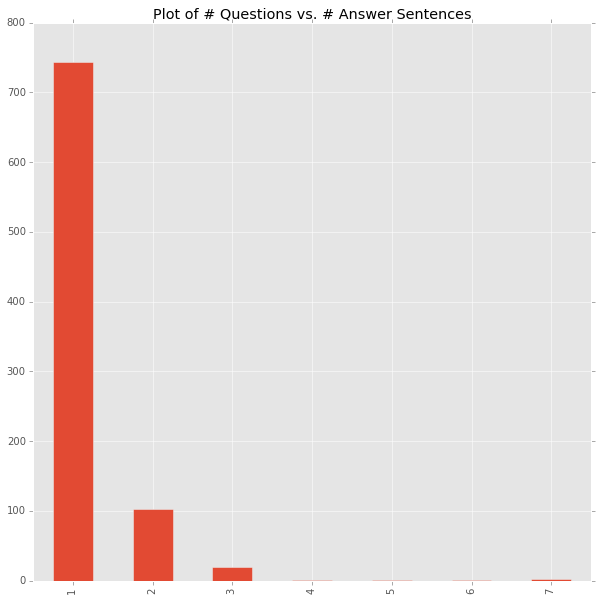

In [127]:
df_temp = positiveTrain_df.groupby('QuestionID').aggregate(sum)['Label'].value_counts().sort_index()
plot = df_temp.plot(kind='bar', figsize=(10, 10))
plot.set_title("Plot of # Questions vs. # Answer Sentences")
"""
for i, label in enumerate(list(df_temp.index)):
    score = df_temp.ix[label][1]
    ax.annotate(str(score), (i, score + 0.2))
    """

In [135]:
positiveTrain_df.to_csv("PositiveQuestions.tsv", sep = '\t')

In [136]:
positiveTrain_df.count()

QuestionID       8666
Question         8666
DocumentID       8666
DocumentTitle    8666
SentenceID       8666
Sentence         8666
Label            8666
dtype: int64

In [236]:
import string, re
import nltk
import math

idfWeights = {}

def removePunctuation(inputString):
    return re.sub('[%s]' % re.escape(string.punctuation), '', inputString)

def removeStopWords(tokens):
    return [t for t in tokens if t not in nltk.corpus.stopwords.words('english')]

def getBigrams(tokens):
    bigrams = []
    for i in range(len(tokens) - 1):
        bigram = tokens[i], tokens[i + 1]
        bigrams.append(bigram)
    return bigrams

def getTrigrams(tokens):
    trigrams = []
    for i in range(len(tokens) - 2):
        trigram = tokens[i], tokens[i + 1], tokens[i + 2]
        trigrams.append(trigram)
    return trigrams
    
def getLemmas(tokens):
    lemmatizer = nltk.WordNetLemmatizer()
    return [lemmatizer.lemmatize(t.decode('utf-8')) for t in tokens]
    
def getIDFWeights(df):
    IDFWeights = {}
    typeList = ['train', 'test', 'dev']
    for rowType in typeList:
        df_specific_type = df[df['Type'] == rowType]
        unique_question_IDs = df_specific_type['QuestionID'].unique()
        for qid in unique_question_IDs:
            df_specific_id = df_specific_type[df_specific_type['QuestionID'] == qid]
            frequencies = {}
            no_of_documents = 0
            for index, row in df_specific_id.iterrows():
                no_of_documents = no_of_documents + 1
                sentence = row['Sentence']
                sentence = removePunctuation(sentence)
                sentence = sentence.lower()
                sTokens = nltk.word_tokenize(sentence)
                sTokens = Set(sTokens)
                for token in sTokens:
                    if frequencies.has_key(token):
                        frequencies[token] = frequencies[token] + 1
                    else:
                        frequencies[token] = 1
            
            for index, row in df_specific_id.iterrows():
                sentence = row['Sentence']
                sentence = removePunctuation(sentence)
                sentence = sentence.lower()
                sTokens = nltk.word_tokenize(sentence)
                sTokens = Set(sTokens)
                sentDict = {}
                for token in sTokens:
                    idfWeight = math.log(no_of_documents) - math.log(frequencies[token])
                    sentDict[token] = idfWeight
                IDFWeights[(rowType, qid, row['SentenceID'])] = sentDict
    return IDFWeights
    
def WordCount(df):
    #Make a dataframe and groupby QuestionID
    columns = ['QuestionID', 'SentenceID', 'Label', 'Type']
    columns = columns + ['Question', 'Sentence']
    features = ['UnigramCount', 'BigramCount', 'TrigramCount', 'LemmaCount', 'IDFUnigramCount']
    dfWordCount = pd.DataFrame(columns = columns + features)
    
    #Get IDF Vectors
    IDFWeights = getIDFWeights(df)
    for index, row in df.iterrows():
        #empty dictionary
        featureVector = {}
        
        question = row['Question']
        sentence = row['Sentence']

        #Remove punctuation 
        question = removePunctuation(question)
        sentence = removePunctuation(sentence)

        #Convert to Lower case
        question = question.lower()
        sentence = sentence.lower()

        featureVector['QuestionID'] = row['QuestionID']
        featureVector['SentenceID'] = row['SentenceID']
        featureVector['Label'] = row['Label']
        featureVector['Type'] = row['Type']
        featureVector['Question'] = question
        featureVector['Sentence'] = sentence
        
        #tokenize
        qTokens = nltk.word_tokenize(question)
        sTokens = nltk.word_tokenize(sentence)
        
        #print len(qTokens), len(sTokens)
        
        #Bigram count
        qBigrams = getBigrams(qTokens)
        sBigrams = getBigrams(sTokens)
        bigramCount = 0
        for i in qBigrams:
            try:
                if i in sBigrams:
                    bigramCount = bigramCount + 1
            except:
                print i, sTokens
        featureVector['BigramCount'] = bigramCount
        
        #Trigram count
        qTrigrams = getTrigrams(qTokens)
        sTrigrams = getTrigrams(sTokens)
        trigramCount = 0
        for i in qTrigrams:
            try:
                if i in sTrigrams:
                    trigramCount = trigramCount + 1
            except:
                print i, sTokens
        featureVector['TrigramCount'] = trigramCount
        
        #Remove stop words
        qTokens = removeStopWords(qTokens)
        sTokens = removeStopWords(sTokens)
        
        #Unigram Count and IDF unigram count
        IDFUnigramCount = 0
        unigramCount = 0
        for i in qTokens:
            try:
                if i in sTokens:
                    unigramCount = unigramCount + 1
                    IDFUnigramCount = IDFUnigramCount + IDFWeights[(row['Type'], row['QuestionID'], row['SentenceID'])][i]
            except:
                print i, sTokens
        featureVector['UnigramCount'] = unigramCount
        featureVector['IDFUnigramCount'] = IDFUnigramCount
        
        #Parent Lemma Unigram Count
        qLemmas = getLemmas(qTokens)
        sLemmas = getLemmas(sTokens)
        lemmaCount = 0
        for i in qLemmas:
            try:
                if i in sLemmas:
                    lemmaCount = lemmaCount + 1
            except:
                    print i, sTokens
        featureVector['LemmaCount'] = lemmaCount
        dfWordCount = dfWordCount.append(pd.DataFrame([featureVector]), ignore_index = True)
    return dfWordCount     

In [237]:
#test
#x = getIDFWeights(positive_df)
import time
%time data_features = WordCount(positive_df)

Wall time: 2min 19s
Time elapsed :  139.279771852


In [379]:
#test
data_features[data_features['QuestionID'] == 'Q1']

,BigramCount,IDFUnigramCount,Label,LemmaCount,Question,QuestionID,Sentence,SentenceID,TrigramCount,Type,UnigramCount
0,0,0.223144,0,2,how are glacier caves formed,Q1,a partly submerged glacier cave on perito more...,D1-0,0,train,1
1,0,0.000000,0,0,how are glacier caves formed,Q1,the ice facade is approximately 60 m high,D1-1,0,train,0
2,0,0.223144,0,2,how are glacier caves formed,Q1,ice formations in the titlis glacier cave,D1-2,0,train,1
3,0,1.832581,1,3,how are glacier caves formed,Q1,a glacier cave is a cave formed within the ice...,D1-3,0,train,2
4,1,1.832581,0,2,how are glacier caves formed,Q1,glacier caves are often called ice caves but ...,D1-4,0,train,2


In [159]:
WordCount(positiveTrain_df)

In [166]:
x = positiveTrain_df[['QuestionID', 'Label']]

In [168]:
from sets import Set
print Set([1,1,1,2,3])

Set([1, 2, 3])


In [177]:
a = [("hello", "kill"), ("hello", "killk")]
("hello", "kills") in a

False

In [205]:
#Load all the data and make one single dataframe
new_train = pd.read_table('E:\Major Project\Data\WikiQACorpus\WikiQA-train.tsv')
new_test = pd.read_table('E:\Major Project\Data\WikiQACorpus\WikiQA-test.tsv')
new_dev = pd.read_table('E:\Major Project\Data\WikiQACorpus\WikiQA-dev.tsv')

#Add type column
new_train['Type'] = 'train'
new_test['Type'] = 'test'
new_dev['Type'] = 'dev'

#Append the dataframes to train
dataset = new_train.append(new_test.append(new_dev, ignore_index = True), ignore_index = True)

In [206]:
print "# answer sentences"
dataset.groupby('Type').sum()

# answer sentences


,Label
Type,
dev,140
test,291
train,1039


In [207]:
dataset.groupby('Type').count()

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
Type,,,,,,,
dev,2733,2733,2733,2733,2733,2733,2733
test,6116,6116,6116,6116,6116,6116,6116
train,20347,20347,20347,20347,20347,20347,20347


In [208]:
dataset.to_csv("DataSet.tsv", sep = '\t')

In [210]:
#Generating only questions with answers dataset
def getPositiveDf(df):
    questionIDs = []
    positiveQuestions = df['QuestionID'][df['Label'] == 1]
    questionIDs = positiveQuestions.tolist()
    temp_df = pd.DataFrame(columns = dataset.columns)
    for index, row in df.iterrows():
        if row['QuestionID'] in questionIDs:
            temp_df.loc[-1] = row  # adding a row
            temp_df.index = temp_df.index + 1  # shifting index
    return temp_df
            
def getPositiveAll(dataset):
    typeList = ['train', 'test', 'dev']
    positive_df = pd.DataFrame(columns = dataset.columns)
    for rowType in typeList:
        df = dataset[dataset['Type'] == rowType]
        positive_df = positive_df.append(getPositiveDf(df), ignore_index = True)
    return positive_df
        
positive_df = getPositiveAll(dataset)

In [211]:
positive_df.groupby('Type').count()

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
Type,,,,,,,
dev,1130,1130,1130,1130,1130,1130,1130
test,2318,2318,2318,2318,2318,2318,2318
train,8666,8666,8666,8666,8666,8666,8666


In [212]:
positive_df.to_csv("Positive_DataSet.tsv", sep = '\t')

In [204]:
#Testing
test_df = pd.DataFrame(columns = ['a', 'b'])
row = {'a': 1, 'b': 2}
row2 = {'b': 2, 'a': 2}
test_df = test_df.append(pd.DataFrame([row]), ignore_index = True)
test_df = test_df.append(pd.DataFrame([row2]), ignore_index = True)
test_df.head()

,a,b
0,1,2
1,2,2


In [215]:
test_df['b'].unique()

array([ 2.])

In [220]:
test = {}
test['a'] = 1
if test.has_key('b'):
    test['b'] = 1
else:
    test['b'] = 1

In [221]:
test[('a','b')] = 1

In [222]:
print test

{'a': 1, ('a', 'b'): 1, 'b': 1}


In [241]:
data_features.to_csv("DataSet_Feature_Extraction_1.tsv", sep = '\t')

In [368]:
import numpy as np
from sklearn.linear_model import LogisticRegression

#Train the model on Logistic Regression
def buildModel(data_type):
    features = ['UnigramCount', 'BigramCount', 'TrigramCount', 'LemmaCount', 'IDFUnigramCount']
    X_Train = data_features[features][data_features['Type'] == 'train']
    y_Train = data_features['Label'][data_features['Type'] == 'train']

    model = LogisticRegression()
    model = model.fit(X_Train, y_Train)

    #Test Set
    X_Test = data_features[features][data_features['Type'] == data_type]
    y_Test = data_features['Label'][data_features['Type'] == data_type]

    y_Test_Predicted = model.predict(X_Test)
    y_Test_Predicted_Probabilites = model.predict_proba(X_Test)
    return y_Test_Predicted_Probabilites


#Calculate MRR
def getMRR(df):
    question_ids = df['QuestionID'].unique()
    rankSum = 0
    for qid in question_ids:
        proba_list = df[df['QuestionID'] == qid]['Probability'].tolist()
        label_list = df[df['QuestionID'] == qid]['Label'].tolist()
        lst = zip(proba_list, label_list)
        lst = np.array(lst)
        lst = lst[np.argsort(lst[:, 0])]
        lst = lst[::-1]
        for i in range(len(lst)):
            if lst[i][1] == 1:
                rankSum = rankSum + (1/ float(i + 1))
                #print qid, i + 1
    mean_reciprocal_rank = rankSum/ float(df['Label'].sum())
    #mrr = rankSum/ float(len(question_ids))
    return mean_reciprocal_rank

#Calculate MAP
def getMAP(df):
    question_ids = df['QuestionID'].unique()
    average_precision_measures = []
    for qid in question_ids:
        proba_list = df[df['QuestionID'] == qid]['Probability'].tolist()
        label_list = df[df['QuestionID'] == qid]['Label'].tolist()
        lst = zip(proba_list, label_list)
        lst = np.array(lst)
        lst = lst[np.argsort(lst[:, 0])]
        lst = lst[::-1]
        no_of_positives = 0
        no_of_documents = 0
        precision_measures = []
        for i in range(len(lst)):
            no_of_documents = no_of_documents + 1
            if lst[i][1] == 1:
                no_of_positives = no_of_positives + 1
                precision = no_of_positives / float(no_of_documents)
                precision_measures.append(precision)
                #print qid, i + 1
        average_precision = np.mean(precision_measures)
        #print precision_measures, average_precision
        average_precision_measures.append(average_precision)
    mean_average_precision = np.mean(average_precision_measures)
    #mrr = rankSum/ float(len(question_ids))
    return mean_average_precision

def evaluateModel(data_type):
    y_Test_Predicted_Probabilites = buildModel(data_type)
    df1 = data_features[data_features['Type'] == data_type]
    df1 = df1.reset_index(drop=True)
    df1 = df1[['QuestionID', 'SentenceID', 'Label', 'Type']]
    df2 = pd.Series(y_Test_Predicted_Probabilites[:, 1], name='Probability')
    df = pd.concat([df1, df2], axis = 1)
    print "Mean Reciprocal Rank : ", getMRR(df)
    print "Mean Average Precision : ", getMAP(df)

evaluateModel('dev')

Mean Reciprocal Rank :  0.564474699903
Mean Average Precision :  0.596179266794


In [273]:
import numpy as np

a = [1, 2, 3]
b = [3, 2, 1]
c = zip(a, b)
c = np.array(c)
print c[np.argsort(c[:,1])]

[[3 1]
 [2 2]
 [1 3]]


In [318]:
df1 = data_features[['QuestionID', 'SentenceID', 'Label']]
print df1.count()
df2 = pd.Series(y_Test_Predicted_Probabilites[:, 1], name='Probability')
print df2.count()
#df[df['QuestionID'] == 'Q220']

QuestionID    12114
SentenceID    12114
Label         12114
dtype: int64
2318


In [350]:
df1 = data_features[data_features['Type'] == 'test']
df1 = df1.reset_index(drop=True)
df1 = df1[['QuestionID', 'SentenceID', 'Label', 'Type']]
df2 = pd.Series(y_Test_Predicted_Probabilites[:, 1], name='Probability')
df = pd.concat([df1, df2], axis = 1)
df

,QuestionID,SentenceID,Label,Type,Probability
0,Q0,D0-0,0,test,0.122264
1,Q0,D0-1,0,test,0.097947
2,Q0,D0-2,0,test,0.194486
3,Q0,D0-3,0,test,0.097947
4,Q0,D0-4,0,test,0.059582
5,Q0,D0-5,1,test,0.141264
6,Q4,D4-0,0,test,0.104247
7,Q4,D4-1,0,test,0.104247
8,Q4,D4-2,0,test,0.104247
9,Q4,D4-3,0,test,0.069614


In [339]:
df1 = data_features[data_features['Type'] == 'test']
df1

,BigramCount,IDFUnigramCount,Label,LemmaCount,Question,QuestionID,Sentence,SentenceID,TrigramCount,Type,UnigramCount
8666,1,0.405465,0,1,how african americans were immigrated to the us,Q0,african immigration to the united states refer...,D0-0,0,test,1
8667,0,0.405465,0,1,how african americans were immigrated to the us,Q0,the term african in the scope of this article ...,D0-1,0,test,1
8668,2,1.791759,0,2,how african americans were immigrated to the us,Q0,from the immigration and nationality act of 19...,D0-2,1,test,1
8669,0,0.405465,0,1,how african americans were immigrated to the us,Q0,african immigrants in the united states come f...,D0-3,0,test,1
8670,0,0.000000,0,0,how african americans were immigrated to the us,Q0,they include people from different national li...,D0-4,0,test,0
8671,1,0.405465,1,2,how african americans were immigrated to the us,Q0,as such african immigrants are to be distingui...,D0-5,0,test,1
8672,0,0.693147,0,1,how a water pump works,Q4,a small electrically powered pump,D4-0,0,test,1
8673,0,0.693147,0,1,how a water pump works,Q4,a large electrically driven pump electropump f...,D4-1,0,test,1
8674,0,0.693147,0,1,how a water pump works,Q4,a pump is a device that moves fluids liquids ...,D4-2,0,test,1
8675,0,0.000000,0,1,how a water pump works,Q4,pumps can be classified into three major group...,D4-3,0,test,0


In [356]:
np.mean([1.1, 2.2, 3.4])

2.2333333333333334